In [1]:
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import open3d
import seaborn as sns
from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. 3D mesh reconstruction from a set of images from the Gerrard Hall dataset.
First, we installed Colmap and runned the automatic reconstruction on the Gerrard Hall dataset. 

After running the automatic reconstruction, we visualized the sparse reconstruction directly in COLMAP. This visualization shows the recovered camera poses (in red) and the 3D sparse point cloud representing the structure of the scene. 

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_colmap.png" width="45%">
</div>


Next, we exported the dense reconstruction and loaded the resulting meshes into MeshLab for further visualization and processing.

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_mesh_before_1.png" width="45%">
  <img src="figures/gerrard_hall_mesh_before_2.png" width="45%">
</div>


However, the raw mesh contained several artifacts and noisy components, especially around the borders and less constrained regions. To improve the final result, we applied different cleaning filters in MeshLab, such as **removing isolated components (wrt Diameter)**, and **manually removed a connected region** that corresponded to a reconstruction artifact by selecting the undesired faces with a rectangular selection tool and deleting the selected vertices and faces. 

The following images correspond to the cleaned versions of the previous meshes, obtained after applying post-processing steps in MeshLab.

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_mesh_after_1.png" width="45%">
  <img src="figures/gerrard_hall_mesh_after_2.png" width="45%">
</div>


The final processed mesh can be downloaded from the following link:
[Gerrard Hall Mesh](https://drive.google.com/file/d/1yNNZeB9sxfI0jd5833KQu7Z_Lk0r3WLD/view?usp=drive_link)

# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [2]:
# Add your path
reconstruction_path = "./gerrard-hall/sparse/0"
database_path = "./gerrard-hall/database.db"

#### Load an existing reconstruction and print its contents

In [3]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

In [4]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [5]:
print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[1]) 

Loaded 100 images. This is the information available for one of them:
Image(id=1, qvec=array([ 0.63708369,  0.22429394, -0.25600195,  0.69157762]), tvec=array([-0.72194622, -1.9670957 ,  2.73841702]), camera_id=1, name='IMG_2387.JPG', xys=array([[ 758.38574219,   61.36777496],
       [2757.86962891,   11.28521633],
       [2775.62963867,   33.56768417],
       ...,
       [1864.0871582 , 3612.57421875],
       [2398.2121582 , 3603.64233398],
       [2398.2121582 , 3603.64233398]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

Loaded 1 cameras. This is the information available for one of them:
Camera(id=1, model='OPENCV', width=5616, height=3744, params=array([ 3.83803963e+03,  3.83703349e+03,  2.80800000e+03,  1.87200000e+03,
       -1.10256401e-01,  7.93806018e-02,  1.17244277e-04,  2.84898767e-04]))

Loaded 42815 3D points. This is the information available for one of them:
Point3D(id=1, xyz=array([-0.03336308, -1.54452335, -1.58907061]), rgb=array([205, 210, 213]), error=arra

#### Load the database

In [6]:
db = sqlite3.connect(database_path)

In [7]:
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

In [8]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

Loaded keypoints from 100 images. These are the 24414 keypoints for one of them:
[[7.5838574e+02 6.1367775e+01]
 [4.0777049e+00 2.3697526e+00]
 [2.7578696e+03 1.1285216e+01]
 ...
 [4.2930962e+01 4.8993421e+00]
 [2.3982122e+03 3.6036423e+03]
 [4.2930962e+01 2.5109098e+00]]


In [9]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

Loaded 2153 matches. 2797/4950 matches contained no data


In [10]:
# Temporal
dir(matches)
matches.__class__
matches.items()
matches.keys()

dict_keys([(1.0, 3), (1.0, 18), (1.0, 26), (1.0, 27), (1.0, 28), (1.0, 35), (1.0, 38), (1.0, 39), (1.0, 42), (1.0, 44), (1.0, 50), (1.0, 56), (1.0, 62), (1.0, 63), (1.0, 64), (1.0, 67), (1.0, 70), (1.0, 75), (1.0, 85), (1.0, 89), (1.0, 99), (2.0, 5), (2.0, 6), (2.0, 7), (2.0, 8), (2.0, 13), (2.0, 20), (2.0, 21), (2.0, 22), (2.0, 23), (2.0, 24), (2.0, 30), (2.0, 32), (2.0, 33), (2.0, 35), (2.0, 37), (2.0, 41), (2.0, 44), (2.0, 45), (2.0, 52), (2.0, 64), (2.0, 65), (2.0, 67), (2.0, 68), (2.0, 69), (2.0, 71), (2.0, 73), (2.0, 77), (2.0, 78), (2.0, 81), (2.0, 84), (2.0, 85), (2.0, 89), (2.0, 93), (2.0, 95), (2.0, 97), (2.0, 98), (3.0, 4), (3.0, 14), (3.0, 15), (3.0, 18), (3.0, 26), (3.0, 27), (3.0, 28), (3.0, 35), (3.0, 38), (3.0, 39), (3.0, 42), (3.0, 44), (3.0, 47), (3.0, 49), (3.0, 50), (3.0, 56), (3.0, 57), (3.0, 62), (3.0, 63), (3.0, 64), (3.0, 67), (3.0, 69), (3.0, 70), (3.0, 71), (3.0, 74), (3.0, 75), (3.0, 79), (3.0, 85), (3.0, 89), (3.0, 94), (3.0, 96), (3.0, 99), (4.0, 5), (4.0, 

In [11]:
print("These are the matches between two images:")
print(matches[1,3])

These are the matches between two images:
[[1459   68]
 [8054  481]
 [8113  482]
 [8114  483]
 [8187  484]
 [6590  512]
 [8009  603]
 [8053  608]
 [8184  611]
 [8111  612]
 [8112  613]
 [8052  774]
 [8182  775]
 [8181  777]
 [5326  783]
 [5806  797]
 [8005  903]
 [8107  907]
 [8110  909]
 [8048  910]
 [8049  911]
 [8180  914]
 [8177  915]
 [8175  916]
 [5067  917]
 [8178  919]
 [5800  926]
 [6416  939]
 [8002 1041]
 [8000 1043]
 [8001 1044]
 [8044 1050]
 [5684 1062]
 [7995 1191]
 [8104 1192]
 [8099 1194]
 [8097 1196]
 [8100 1197]
 [8096 1198]
 [8169 1200]
 [8171 1201]
 [6658 1223]
 [8039 1339]
 [8092 1340]
 [8088 1341]
 [8094 1342]
 [8168 1343]
 [6477 1384]
 [7172 1397]
 [7173 1398]
 [7170 1399]
 [7168 1400]
 [7994 1491]
 [7991 1492]
 [7992 1493]
 [8036 1496]
 [7993 1498]
 [8087 1505]
 [5912 1525]
 [7003 1549]
 [7002 1550]
 [7986 1684]
 [8032 1685]
 [8165 1687]
 [8163 1688]
 [6570 1709]
 [6565 1710]
 [7237 1735]
 [8033 1855]
 [8031 1856]
 [8086 1857]
 [8085 1858]
 [8162 1860]
 [5436 18

#### Visualize the point cloud and cameras

In [12]:
model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [13]:
print(f"#Keypoints total: {sum(kpts.shape[0] for kpts in keypoints.values())}")

#Keypoints total: 2123400


<span style='color:darkcyan'>There are 2123400 keypoints in total.</span> 

#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [14]:
num_points3d_originated_in_image_1 = sum(1 for point3D in points3D.values() if 1 in point3D.image_ids)

print(f"#3d points from image 1: {num_points3d_originated_in_image_1}")

#3d points from image 1: 2824


<span style='color:darkcyan'>There are 2824 keypoints in image 1.</span> 

## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

In [15]:
xyz = []
num_images = []
errors = []

for point3D in points3D.values():
    xyz.append(point3D.xyz)
    num_images.append(len(point3D.image_ids))
    errors.append(point3D.error)

xyz = np.array(xyz)
num_images = np.array(num_images)
errors = np.array(errors)

num_images_norm = (num_images - num_images.min()) / (num_images.max() - num_images.min())
errors_norm = (errors - errors.min()) / (errors.max() - errors.min())


colors_by_images = cm.jet(num_images_norm)[:, :3]
colors_by_error = cm.jet(errors_norm)[:, :3]

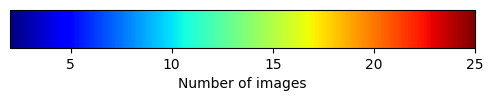

In [16]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=num_images.min(), vmax=num_images.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Number of images')
plt.show()

In [17]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_images)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

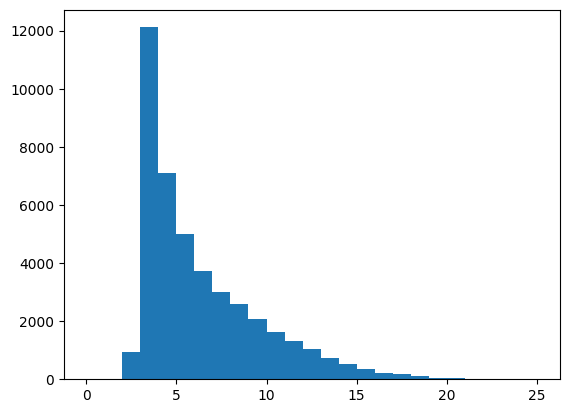

In [18]:
# Let's plot a histogram too
images_per_point3d = [len(p3d.image_ids) for p3d in points3D.values()]
counts, bins = np.histogram(images_per_point3d, bins=[i for i in range(max(images_per_point3d) + 1)])
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>Most points are visible from a few images. MORE</span> 

#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

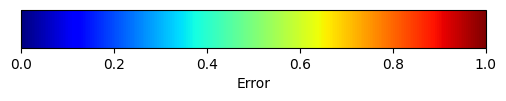

In [19]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=errors_norm.min(), vmax=errors_norm.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Error')
plt.show()

In [20]:
vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_error)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

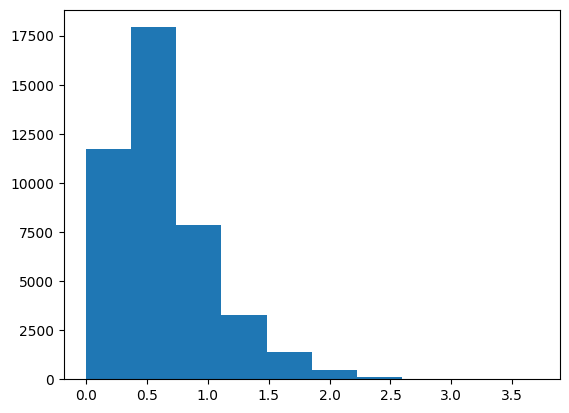

In [21]:
# Let's plot a histogram too
error_per_point3d = [p3d.error for p3d in points3D.values()]
counts, bins = np.histogram(error_per_point3d)
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>The error property of a 3D point is the average reprojection error of the point accross all images that can see said point.</span> 

<span style='color:darkcyan'>The error of the 3D points seems to have a more normal distribution. MORE</span> 

## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


In [22]:
xyz = []
colors = []

for point3D in points3D.values():
    if 1 not in point3D.image_ids:
        continue
    xyz.append(point3D.xyz)
    colors.append(point3D.rgb / 255)

vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

<class 'numpy.ndarray'>
(24414, 2)
float32
<class 'read_write_model.Image'>
<class 'numpy.ndarray'>


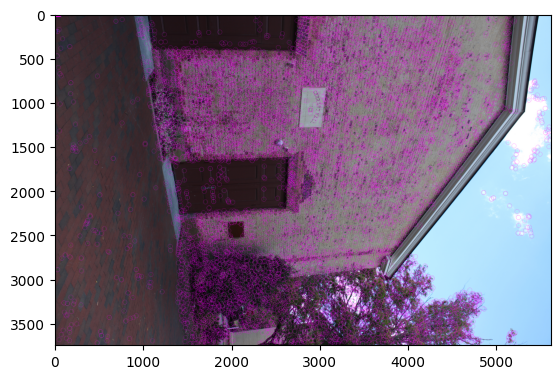

In [23]:
image1_keypoints = keypoints[1]

cv_keypoints = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=50) 
                for pt in image1_keypoints]


images_path = "./gerrard-hall/images/"

print(type(image1_keypoints))
print(image1_keypoints.shape)
print(image1_keypoints.dtype)

print(type(images[1]))

im1 = cv2.imread(images_path + images[1].name)
print(type(im1))
im_with_kpts = cv2.drawKeypoints(im1, cv_keypoints, None, 
                                   color=(255, 0, 255),
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

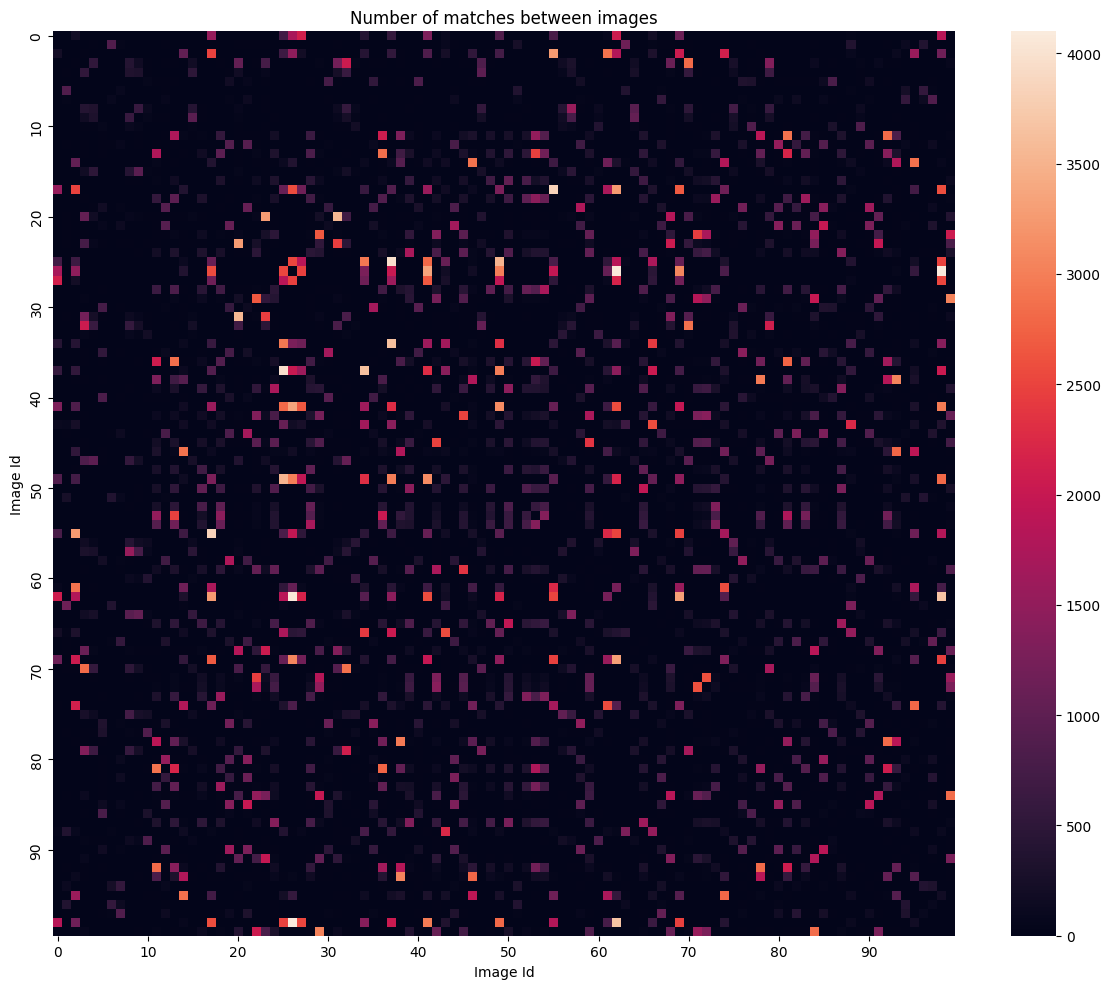

In [24]:
num_images = max(images.keys())
match_matrix = np.zeros((num_images, num_images), dtype=np.int32)
for (id1, id2), match_data in matches.items():
    i, j = int(id1) - 1, int(id2) - 1
    num_matches = len(match_data)
    match_matrix[i, j] = num_matches
    match_matrix[j, i] = num_matches

plt.figure(figsize=(12, 10))
sns.heatmap(match_matrix, xticklabels=10, yticklabels=10)
plt.xlabel('Image Id')
plt.ylabel('Image Id')
plt.title('Number of matches between images')
plt.tight_layout()
plt.show()

<span style='color:darkcyan'>Matches are concentrated around each image. An image won't have matches with images too far apart, as they represent different parts of the scene - images far appart may show different facades of the building. The fact that the corners of the heatmap are not 0 indicates that the last few images match with the first ones, indicating a somewhat closed track.</span> 

## 2.5 Visualize the keypoints and matches between the two images used in lab 3 using Colmap, how it compares to the results from lab 3? (1.0)
#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 3 to get comparable results. </span>

In [ ]:
### TO DO 2.5

## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 3, how it compares to the results from lab 3? (1.0) 
#### <span style='color:Green'> - Use the triangulation from lab 3 to the get the 3D points and visualize them following the same style. </span>

In [ ]:
### TO DO 2.6

## 2.7 Visualize the sparse reconstruction using the 2 images from lab 3, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

In [ ]:
### TO DO 2.7